In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import norm
from scipy.fftpack import fft
% matplotlib inline

In [2]:
def random_sine(T):
    u = np.arange(T, dtype = 'double') / T
    f = np.random.choice(np.arange(1,5))
    phi = 2*np.pi*np.random.rand()
    
    return np.sin(2*np.pi*u*f + phi) / 2

In [3]:
def random_sum_sine(p, T):
    u = np.arange(T, dtype = 'double') / T
    f = np.array([np.random.choice(np.arange(1,10,1)) for i in np.arange(p)], dtype = 'double')
    A = np.array([np.random.choice(np.arange(-5,5,1)) for i in np.arange(p)], dtype = 'double')
    phi = 2*np.pi * np.array([np.random.choice(np.arange(0,1,0.01)) for i in np.arange(p)], dtype = 'double')
    
    out = np.zeros(T)
    for k in np.arange(p):
        out += A[k] * np.sin(2*np.pi*u*f[k] + phi[k])
        
    return out / (1.5 *np.max(abs(out)))

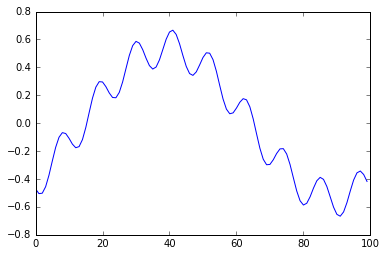

In [4]:
sine = random_sum_sine(2,100)
plt.plot(sine)

In [5]:
def generation_TVAR(d,T,kappa):
    theta = np.zeros((d,T),dtype='double')
    theta_int = np.zeros((d,d),dtype='double')
    epsilon = np.random.randn(2*T)
    X = np.zeros(2*T)
    
    for t in np.arange(T):
        # initialisation
        for p in np.arange(d):
            theta_int[p,p]=kappa[p,t]
        # recurrence
        for p in np.arange(1,d):
            for m in np.arange(p):
                #if t ==0:
                #    print("theta(%s,%s)=theta(%s,%s) - kappa(%s)*theta(%s,%s)"%(m,p,m,p-1,p,p-1-m,p-1))
                theta_int[m,p] = theta_int[m,p-1] - kappa[p,t]*theta_int[p-1-m,p-1]
        theta[:,t] = theta_int[:,-1]
        # calcul de X 
        X[T+t] = np.dot(theta[:,t].T,X[T+t-d:T+t][::-1]) + epsilon[t+T]
    return X,X[T:],theta

[ 1.54107462  1.39583775  1.39583775]


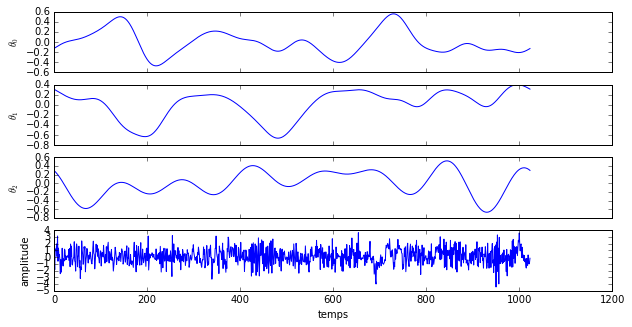

In [47]:
d = 3
T=int(2**10)
kappa = np.zeros((d,T))
for k in np.arange(d):
    kappa[k,:] = np.sin(2*np.pi*k*np.arange(T)/T)/2
    kappa[k,:] = random_sum_sine(6,T)
X_tot, X, theta = generation_TVAR(d, T, kappa)

coeffs = np.ones((d+1,T))
coeffs[1:,:] = -theta #polynome caracteristique
roots = np.roots(coeffs[:,100][::-1])
print(abs(roots))


fig,ax = plt.subplots(d+1,1,figsize=(10,5))
for k in np.arange(d):
    ax[k].plot(theta[k,:])
    plt.setp(ax[k].get_xticklabels(), visible=False)
    ax[k].set_ylabel(r"$\theta_{%s}$"%k)

ax[d].plot(X)
ax[d].set_xlabel('temps')
ax[d].set_ylabel('amplitude')

## Estimation

In [6]:
def generation_est2(X, d, T, mu):
    theta_est = np.zeros((d,T),dtype='double')
    X_pred = np.zeros(T,dtype='double')
    XX = X[0:d][::-1]
    for t in np.arange(d,T):
        err = X[t]-np.dot(theta_est[:,t-1].T,XX)
        
        theta_est[:,t] = theta_est[:,t-1] + mu*XX/(1+mu*np.linalg.norm(XX)**2)*err
        X_pred[t] = np.dot(theta_est[:,t].T,XX)
        
        XX = X[t-d:t][::-1]
        
        #if t < d+5:
        #    print("X(%s)=%s,X(%s)=%s,X(%s)=%s"%(t-1,XX[0],t-2,XX[1],t-3,XX[2]))
        #    print("X(%s)=%s:"%(t,X[t]))
        #    print("valeur actuelle estimee:",np.dot(theta_est[:,t-1].T,XX))
        #    print("erreur :", err)
        #    print("theta(t) :",theta_est[:,t])
        #    print("Xpred(t) :", X_pred[t])
    
    return X_pred, theta_est

In [ ]:
def generation_est(X, d, T, mu):
    # Info : X est de longueur 2*T pour avoir les temps negatifs
    theta_est = np.zeros((d,T),dtype='complex')
    X_est = np.zeros(T,dtype='complex')  
    for k in (np.arange(T)): # on fait T itérations
        XX = X[T+k-d:T+k][::-1]
        if k==0:
            theta_est[:,k] = (mu * X[T+k] * XX / (1 + mu * norm(XX) ** 2))
            theta_est[:,k] = np.zeros(d,dtype='complex')
        else:
            theta_est[:,k] = (theta_est[:,k-1].T + mu * (X[T+k] - np.dot(XX, theta_est[:,k-1])) * XX / (1 + mu * norm(XX) ** 2)) 
        pred = np.dot(XX, theta_est[:,k])
        X_est[k] = pred
    return X_est, theta_est

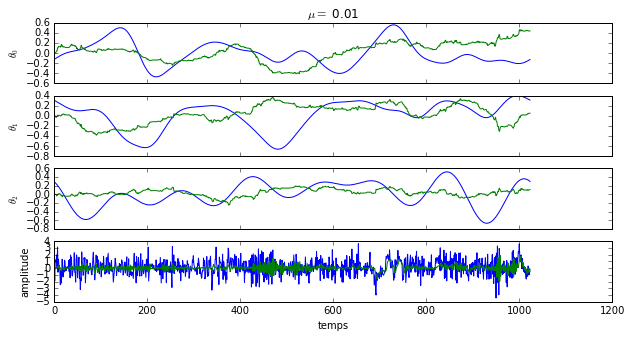

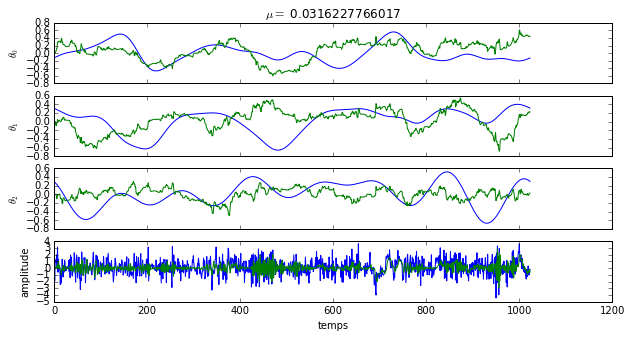

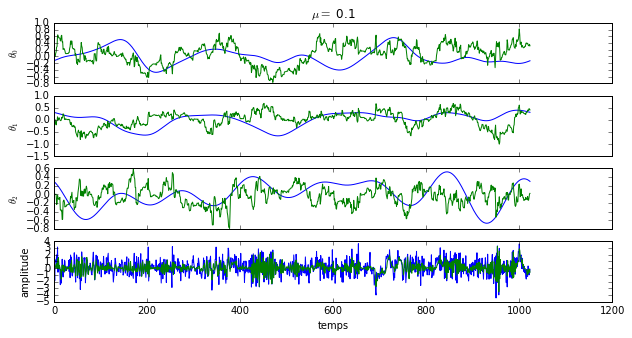

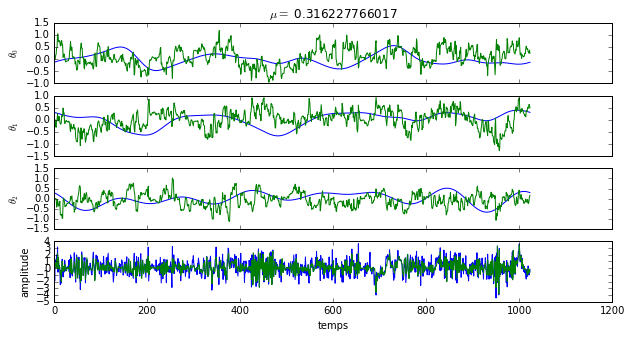

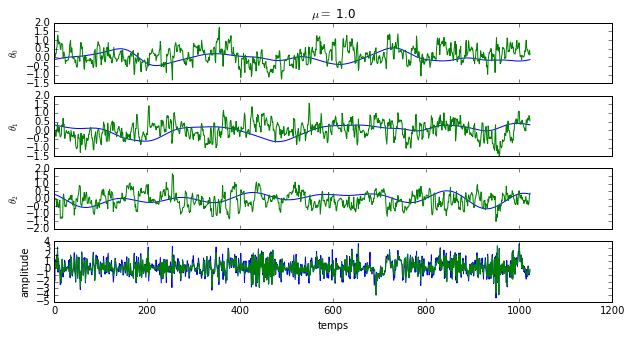

In [63]:
log_mu = np.arange(-2,0.5,0.5)
N = len(log_mu)
mu = np.power(10,log_mu)
MSE_pred = np.zeros(N)
MSE_estim = np.zeros(N)
for n in np.arange(N):

    # test estimation 
    X_pred, theta_est = generation_est2(X,d,T,mu[n])
    fig,ax = plt.subplots(d+1,1,figsize=(10,5))
    for k in np.arange(d):
        ax[k].plot(theta[k,:])
        ax[k].plot(theta_est[k,:])
        plt.setp(ax[k].get_xticklabels(), visible=False)
        ax[k].set_ylabel(r"$\theta_{%s}$"%k)
    ax[d].plot(X)
    ax[d].plot(X_pred)
    ax[d].set_xlabel('temps')
    ax[d].set_ylabel('amplitude')
    ax[0].set_title(r"$\mu=$ %s"%mu[n])
    
    
    MSE_pred[n]=2./T*np.sum((X_pred[int(T/2):]-X[int(T/2):])**2)
    MSE_estim[n]=2./T*np.sum(np.linalg.norm(theta_est[:,int(T/2):]-theta[:,int(T/2):],axis=0)**2)
    


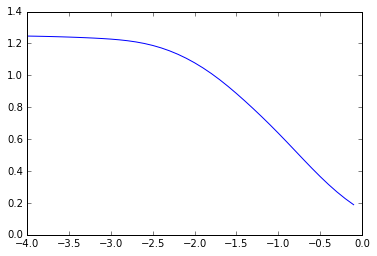

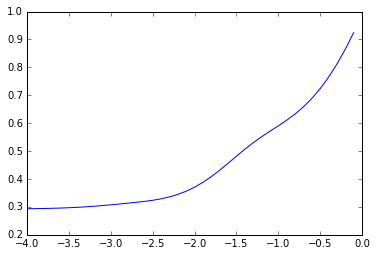

In [37]:
plt.plot(log_mu,MSE_pred)
plt.figure()
plt.plot(log_mu,MSE_estim)

## Agrégation

In [27]:
def aggregation(X, predictions, estimations, d, T, eta, strategy = 1):    
    # predictions : N*T
    # estimations : N*d*T
    N = predictions.shape[0]
    pred = np.zeros(T,dtype='double')
    estim = np.zeros((d,T), dtype='double')
    alpha = np.zeros((N,T),dtype='double')
    # Initialisation :
    alpha[:,0] = 1./N*np.ones(N,dtype='double')
    pred[0] = np.dot(predictions[:,0].T,alpha[:,0])
    estim[:,0] = np.dot(estimations[:,:,0].T,alpha[:,0])
    
    # Mise a jour :
    for t in np.arange(1,T):
        v = np.zeros(N,dtype='double')
        for i in np.arange(N):
            if strategy==1:
                v[i]=alpha[i,t-1]*np.exp(-2*eta*(pred[t-1]-X[t-1])*predictions[i,t-1])
            else:
                v[i]=alpha[i,t-1]*np.exp(-eta*(predictions[i,t-1]-X[t-1])**2)
        alpha[:,t]= v / np.sum(v)
        
        pred[t] = np.dot(predictions[:,t].T,alpha[:,t])
        estim[:,0] = np.dot(estimations[:,:,t].T,alpha[:,t])
        
    return pred,estim
    

### Test agrégation 

In [29]:
def gener_beta(beta0,N):
    beta = np.zeros(N,dtype='double')
    for i in np.arange(N):
        beta[i] = (i-1)*beta0/N
    return beta

In [40]:
N = int(np.ceil(np.log(T)))
beta = gener_beta(0.5,N)
mu = np.power(T, -2*beta/(2*beta+1))


log_mu = np.arange(-4,0,0.1)
N = len(log_mu)
mu = np.power(10,log_mu)

M = 2

MSE_pred = np.zeros((M,N),dtype='double')
MSE_estim = np.zeros((M,N),dtype='double')

MSE_pred_agr1 = np.zeros(M,dtype='double')
MSE_estim_agr1 = np.zeros(M,dtype='double')
MSE_pred_agr2 = np.zeros(M,dtype='double')
MSE_estim_agr2 = np.zeros(M,dtype='double')

eta = np.sqrt(np.log(np.ceil(np.log(T)))/T)
for l in np.arange(M):
    X_tot, X, theta = generation_TVAR(d, T, kappa)
    
    X_pred = np.zeros((N,T),dtype='double')
    theta_est = np.zeros((N,d,T),dtype='double')


    for k in np.arange(N):
        X_pred[k,:], theta_est[k,:,:] = generation_est2(X,d,T,mu[k])
        MSE_pred[l,k]=2./T*np.sum((X_pred[k,int(T/2):]-X[int(T/2):])**2)
        MSE_estim[l,k]=2./T*np.sum(np.linalg.norm(theta_est[k,:,int(T/2):]-theta[:,int(T/2):],axis=0)**2)
    
    X_pred_agr1, theta_est_agr1 = aggregation(X, X_pred,theta_est, d, T, eta, 1) 
    X_pred_agr2, theta_est_agr2 = aggregation(X, X_pred,theta_est, d, T, eta, 2)    

    MSE_pred_agr1[l] = 2./T*np.sum((X_pred_agr1[int(T/2):]-X[int(T/2):])**2)
    MSE_estim_agr1[l] = 2./T*np.sum(np.linalg.norm(theta_est_agr1[:,int(T/2):]-theta[:,int(T/2):],axis=0)**2)
    
    MSE_pred_agr2[l] = 2./T*np.sum((X_pred_agr2[T/2:]-X[T/2:])**2)
    MSE_estim_agr2[l] = 2./T*np.sum(np.linalg.norm(theta_est_agr2[:,int(T/2):]-theta[:,int(T/2):],axis=0)**2)

MISE_pred = np.mean(MSE_pred,axis=0)
MISE_estim = np.mean(MSE_estim,axis=0)
MISE_pred_agr1 = np.mean(MSE_pred_agr1)
MISE_estim_agr1 = np.mean(MSE_estim_agr1)
MISE_pred_agr2 = np.mean(MSE_pred_agr2)
MISE_estim_agr2 = np.mean(MSE_estim_agr2)

C:\Users\Amaury\Anaconda3\lib\site-packages\ipykernel\__main__.py:39: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


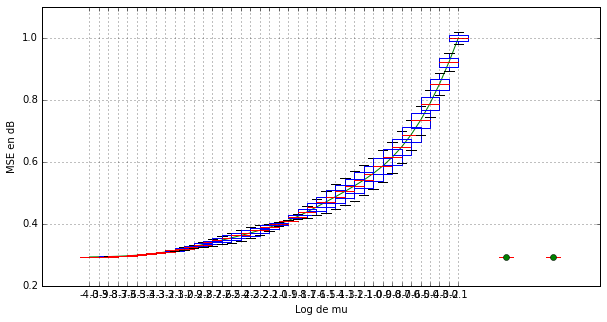

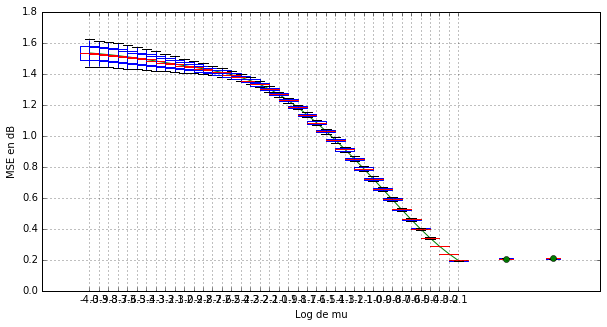

In [41]:
#log_mu = np.arange(N)
log_mu_max = np.max(log_mu)

plt.figure(figsize=(10,5))
plt.plot(log_mu, MISE_estim, 'g')
plt.boxplot(MSE_estim_agr2, positions = [log_mu_max+1]) 
plt.boxplot(MSE_estim_agr1, positions = [log_mu_max+0.5]) 
plt.boxplot(MSE_estim, positions = log_mu, widths = 0.2 * np.ones(N))
plt.plot(log_mu_max+0.5, MISE_estim_agr1, 'og')
plt.plot(log_mu_max+1, MISE_estim_agr2, 'og')
plt.xlabel("Log de mu")
plt.ylabel("MSE en dB")
plt.xlim([np.min(log_mu)-0.5,log_mu_max+1.5])
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(log_mu, MISE_pred, 'g')
plt.boxplot(MSE_pred_agr2, positions = [log_mu_max+1]) 
plt.boxplot(MSE_pred_agr1, positions = [log_mu_max+0.5]) 
plt.boxplot(MSE_pred, positions = log_mu, widths = 0.2 * np.ones(N))
plt.plot(log_mu_max+0.5, MISE_pred_agr1, 'og')
plt.plot(log_mu_max+1, MISE_pred_agr2, 'og')
plt.xlabel("Log de mu")
plt.ylabel("MSE en dB")
plt.xlim([np.min(log_mu)-0.5,log_mu_max+1.5])
plt.grid(True)
plt.show()

In [ ]:
print(MISE_pred_agr1-np.min(MISE_pred))
print(MISE_pred_agr2-np.min(MISE_pred))

In [ ]:
print(np.min(MSE_pred))

## DSP

In [66]:
from scipy.fftpack import fft

def dsp(theta, T, N = 512):
    dsp_array = np.matrix(np.zeros((N, T)))
    
    for t in np.arange(T):
        dsp_array[:,t] = np.matrix(1./abs(fft(theta[:,t].T, N)) ** 2).T
        
    lambd = np.arange(N, dtype = 'double')/N
        
    return lambd, dsp_array

Les racines du polynome caractéristique sont :
(-7.542366852908924+0j) de phase 1.0
(0.10725032019161809+1.458717865768687j) de phase 0.7383193585201362
(0.10725032019161809-1.458717865768687j) de phase 0.2616806414798639


C:\Users\Amaury\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


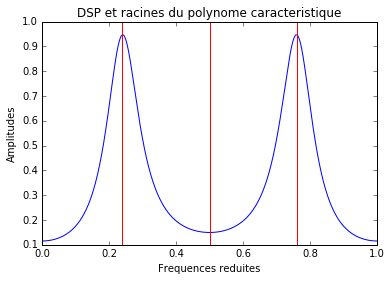

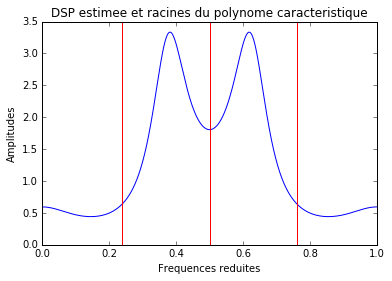

In [67]:
X_pred, theta_est = generation_est2(X,d,T,0.1)

N = 2**12

coeffs = np.ones((d+1,T))
coeffs[1:,:] = -theta #polynome caractértistique

coeffs_est = np.ones((d+1,T))
coeffs_est[1:,:] = -theta_est #polynome caractértistique

f, dsp_X = dsp(coeffs, T, N)
f, dsp_X_est = dsp(coeffs_est, T, N)


roots = np.roots(coeffs[:,T/2][::-1])
angles = (np.angle(roots) + np.pi) / (2*np.pi)

print("Les racines du polynome caractéristique sont :")
for k in np.arange(d):
    print("{} de phase {}".format(roots[k], angles[k]))

        
lambd = np.arange(N, dtype = 'double') / N

plt.figure()
plt.plot(lambd, dsp_X[:,T/2]/np.max(abs(dsp_X[:,0])), 'b', label ='vraie DSP')
for k in np.arange(d):
    if angles[k] >=0 and angles[k] <=0.5:
        plt.axvline(x=angles[k]+0.5, ymin=0, ymax=1, linewidth=1, color = 'r')
    else:
        plt.axvline(x=angles[k]-0.5, ymin=0, ymax=1, linewidth=1, color = 'r')
plt.xlabel("Frequences reduites")
plt.ylabel("Amplitudes")
plt.title("DSP et racines du polynome caracteristique")

plt.figure()
plt.plot(lambd, dsp_X_est[:,T/2]/np.max(abs(dsp_X_est[:,0])), 'b', label = 'DSP estimee')
for k in np.arange(d):
    if angles[k] >=0 and angles[k] <=0.5:
        plt.axvline(x=angles[k]+0.5, ymin=0, ymax=1, linewidth=1, color = 'r')
    else:
        plt.axvline(x=angles[k]-0.5, ymin=0, ymax=1, linewidth=1, color = 'r')
plt.xlabel("Frequences reduites")
plt.ylabel("Amplitudes")
plt.title("DSP estimee et racines du polynome caracteristique")